In [ ]:
from typing import Literal

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

from joblib import dump, load

import shap

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#import for github run
from src.const import DATA_HEAD, WEIGHTS_HEAD
ML_dir = WEIGHTS_HEAD / "ML"

base_df = DATA_HEAD / "STORM_preprocessed_medianfill_1.csv"

In [ ]:
#import for github run
from src.const import CATEGORICAL_TARGETS, LINEAR_TARGETS ATTRIBUTES

In [ ]:
#import for colab run
from const import WEIGHTS_HEAD, DATA_HEAD

data_filename = "STORM_preprocessed_medianfill_1.csv"
base_df = pd.read_csv(str(data_filename), index_col=0)
base_df.head()

,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,OFDAResponse,Appeal,Declaration,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$),CPI
0,STORM_NAN_1953,NaN,1953,9,Storm,Tropical cyclone,8,0,0,0,0,0,92,989,1000,20,19400,211880,9.156133
1,STORM_VIOLET_1964,Violet,1964,9,Storm,Tropical cyclone,4,1,1,0,0,0,92,989,18,20,10000,94354,10.598376
2,STORM_IRIS_1964,Iris,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,150,960,5100,20,70000,660479,10.598376
3,STORM_JOAN_1964,Joan,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,130,980,2500,20,15000,141531,10.598376
4,STORM_KATE_1964,Kate,1964,11,Storm,Tropical cyclone,6,1,0,0,0,0,130,970,0,20,3000,28306,10.598376


In [ ]:
#import for colab run
LINEAR_TARGETS = ["TotalDeaths", "NoInjured", "TotalDamageAdjusted(000US$)"]
CATEGORICAL_TARGETS = ['Flood', 'Slide']
ATTRIBUTES = ['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']

# Featue importance

target: death, injure, total dmg adjust . metric: mse, terminate the large error in predict dmg, phu hop voi gbms


| **Mô hình**               | **Ưu điểm**                            | **Nhược điểm**                          | **Khi nào dùng?**                       |
|---------------------------|----------------------------------------|-----------------------------------------|----------------------------------------|
| XGBoost                   | High efficiency, prevents overfitting       | Resource-intensive, slow training        | Large datasets, many features               |
| LightGBM                  | Extremely fast, efficient on large datasets       | Less accurate with small datasets         | Speed-critical tasks, large datasets, quick prototyping        |
| CatBoost                  | Excellent with categorical features, no encoding needed              | High memory usage, slower with complex features                    | Datasets with many categorical variables, minimal preprocessing                       |
| AdaBoost                  | Simple, easy to interpret, reduces bias                | Less effective on complex data, sensitive to noise          | Smaller datasets, low variance data, interpretable models                       |
| Decision Trees (GBDT)     | Captures non-linear relationships well, interpretable| Can overfit, computationally expensive with many trees               | Complex interactions, non-linear data, explainable models                     |
| NGBoost                   | Models uncertainty, handles complex data         | Requires expertise, less common, slower               |Probabilistic predictions, experimental setups                   |

**Model selection**
1. `XGBoost`
   - XGBoost is highly effective for data that contains both linear and non-linear relationships.
   - It is suitable for datasets with many features, where overfitting might be a concern. XGBoost provides robust feature importance, making it ideal for understanding key factors in complex datasets.
2. `LightGBM`
   - LightGBM is a fast and efficient model that is particularly effective on datasets with a large number of features.
   - It is suitable when quick training is required without sacrificing performance, making it a strong option when speed is prioritized and feature importance needs to be calculated quickly.
3. `CatBoost`
   - CatBoost is designed to handle datasets with many categorical variables without the need for extensive preprocessing, such as one-hot encoding.
   - It is particularly useful when working with datasets that contain mixed feature types (numerical and categorical) and when minimal data preprocessing is desired, while still delivering accurate feature importance.
4. `Decision Trees (GBDT)`
   - Decision Trees (GBDT) are effective at capturing complex, non-linear patterns in data.
   - It is suitable for datasets with non-linear relationships and complex interactions between features, especially when the goal is to model accurate predictions while identifying the most important features contributing to those predictions.

# 1. LINEAR_TARGET


## 1.1.  No Death

In [ ]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[0]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :TotalDeaths
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.1.1 XGBOOST

In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


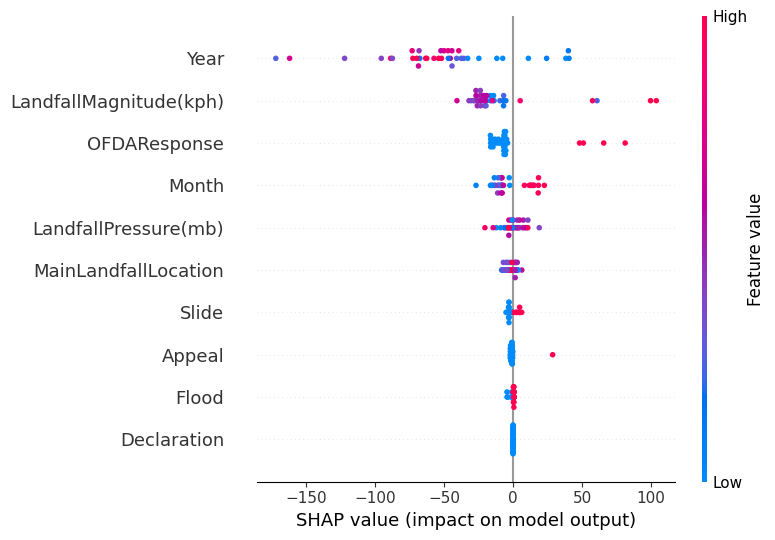

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.2 LightGBM

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [ ]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


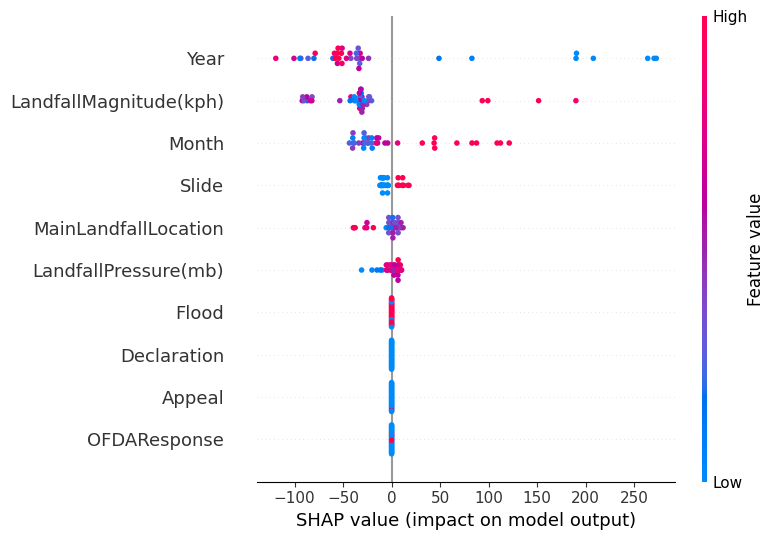

In [ ]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.3 CatBoost

In [ ]:
#install for colab run
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 837us	remaining: 837ms
1:	learn: 471.3640040	total: 1.63ms	remaining: 813ms
2:	learn: 468.0167703	total: 2.33ms	remaining: 776ms
3:	learn: 464.5655498	total: 3.01ms	remaining: 749ms
4:	learn: 461.0471589	total: 3.64ms	remaining: 725ms
5:	learn: 457.8991406	total: 4.24ms	remaining: 703ms
6:	learn: 454.6768441	total: 4.89ms	remaining: 693ms
7:	learn: 451.5365131	total: 5.67ms	remaining: 703ms
8:	learn: 448.4834973	total: 6.31ms	remaining: 695ms
9:	learn: 445.1840673	total: 6.97ms	remaining: 690ms
10:	learn: 441.9371963	total: 7.63ms	remaining: 686ms
11:	learn: 438.6976759	total: 8.35ms	remaining: 688ms
12:	learn: 435.4896915	total: 9.01ms	remaining: 684ms
13:	learn: 432.2595625	total: 9.8ms	remaining: 690ms
14:	learn: 429.0760846	total: 10.4ms	remaining: 684ms
15:	learn: 426.1680837	total: 11ms	remaining: 679ms
16:	learn: 423.0339016	total: 11.6ms	remaining: 673ms
17:	learn: 419.9474727	total: 12.3ms	remaining: 670ms
18:	learn: 4

In [ ]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


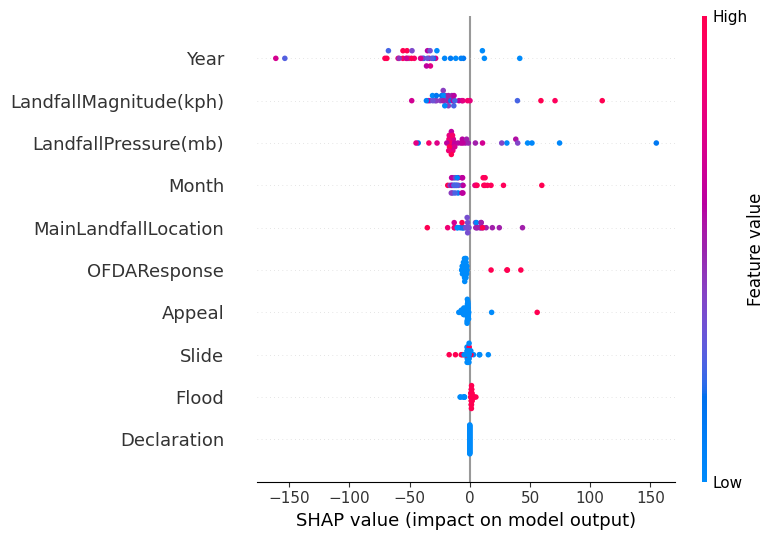

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.4 Decision Trees (GBDT)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor  # GBDT from scikit-learn
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.411417
7    LandfallPressure(mb)    0.407889
6  LandfallMagnitude(kph)    0.080351
2    MainLandfallLocation    0.061992
9                   Slide    0.016216
1                   Month    0.014803
3            OFDAResponse    0.003315
4                  Appeal    0.003182
8                   Flood    0.000834
5             Declaration    0.000000


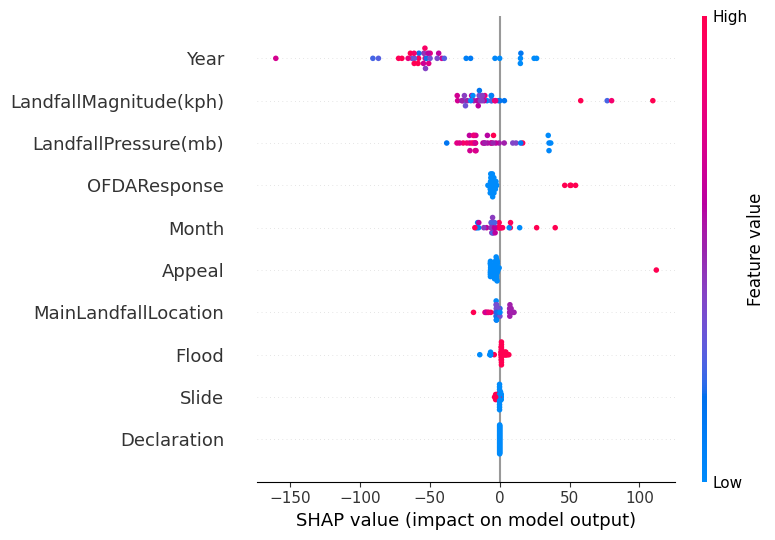

In [ ]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.1.5 COMPARISION

In [ ]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        1.0       1.0       1.0   1.0         1.000
LandfallMagnitude(kph)      2.0       3.0       3.0   3.0         2.750
LandfallPressure(mb)        5.0       4.0       2.0   2.0         3.250
MainLandfallLocation        3.0       6.0       4.0   4.0         4.250
Month                       4.0       2.0       5.0   6.0         4.250
Slide                       8.0       5.0       6.0   5.0         6.000
OFDAResponse                6.0       8.5       8.0   7.0         7.375
Appeal                      7.0       8.5       7.0   8.0         7.625
Flood                       9.0       8.5       9.0   9.0         8.875
Declaration                10.0       8.5      10.0  10.0         9.625


In [ ]:

models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)

mean_abs_shap_df['Avg SHAP'] = mean_abs_shap_df.mean(axis=1)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=False)

print("Sorted Mean Absolute SHAP Values Across Models:")
print(sorted_shap_df)

top_features = sorted_shap_df.head(7)
print("\nTop Features Selected Based on SHAP Values:")
print(top_features[['Avg SHAP']])


Sorted Mean Absolute SHAP Values Across Models:
                          XGBoost   LightGBM   CatBoost       GBDT   Avg SHAP
Year                    58.174931  85.295472  45.044696  50.421724  59.734205
LandfallMagnitude(kph)  26.624462  55.006275  25.662898  21.851117  32.286188
Month                   12.014859  38.545688  12.966990   8.166101  17.923410
LandfallPressure(mb)     5.550518   6.504171  24.649947  17.451981  13.539154
OFDAResponse            14.861990   0.000000   6.987665   9.910908   7.940141
MainLandfallLocation     3.558130   8.868778   9.778090   5.351077   6.889019
Slide                    3.092112   8.942786   3.263049   0.966875   4.066206
Appeal                   1.866562   0.000000   5.049287   6.553165   3.367254
Flood                    0.825314   0.000000   2.419387   3.208163   1.613216
Declaration              0.000000   0.000000   0.000000   0.000000   0.000000

Top Features Selected Based on SHAP Values:
                         Avg SHAP
Year           

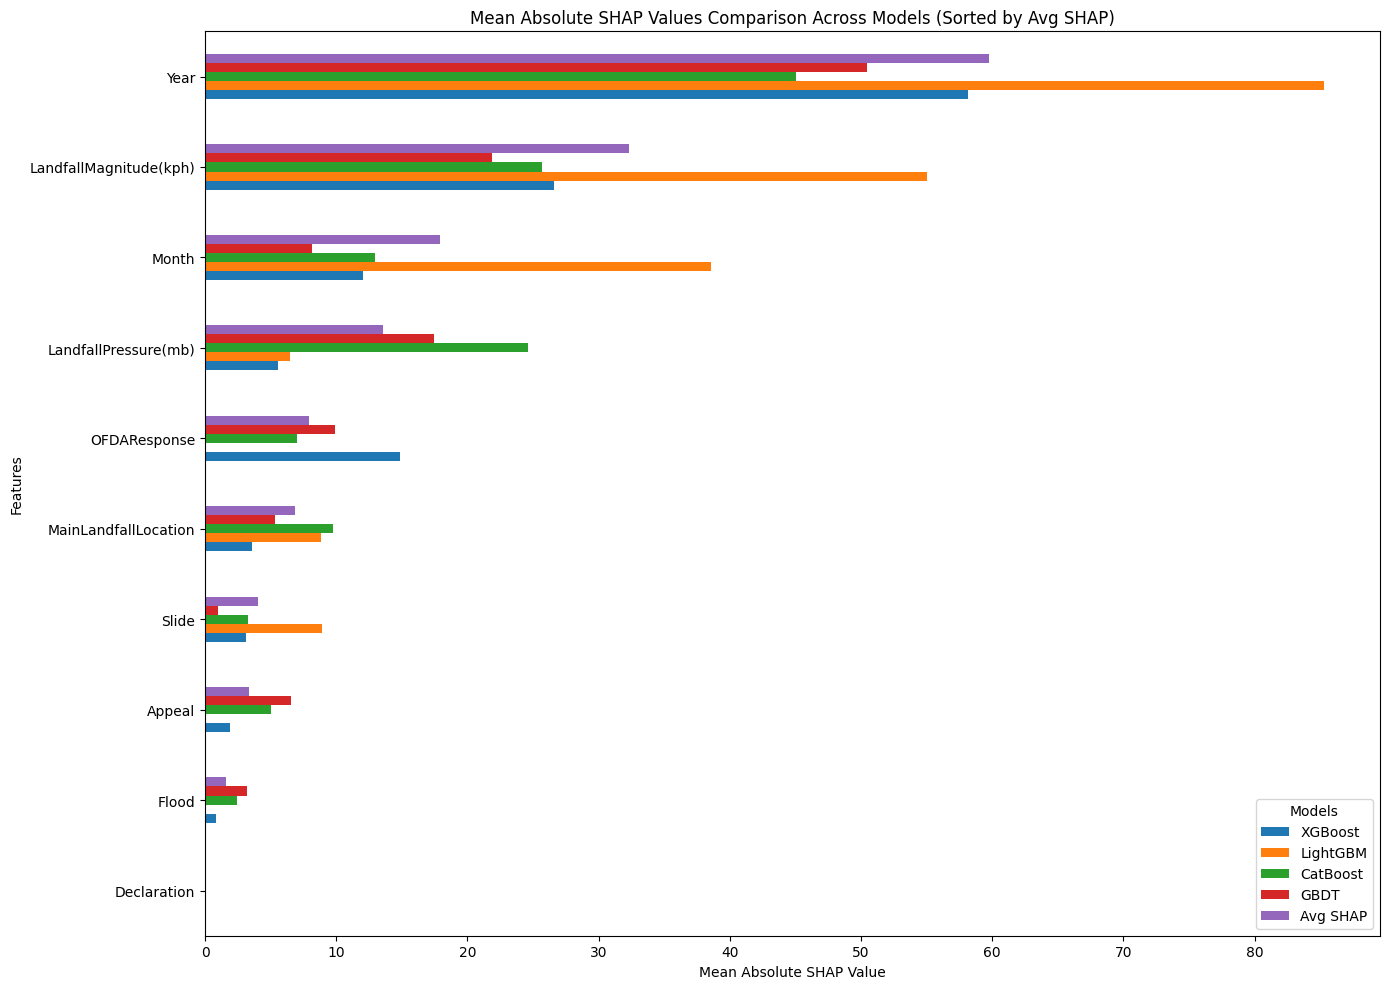

In [ ]:
mean_abs_shap_df.rename(columns={'Avg SHAP': 'Avg SHAP'}, inplace=True)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=True)

sorted_shap_df[['XGBoost', 'LightGBM', 'CatBoost', 'GBDT', 'Avg SHAP']].plot(kind='barh', figsize=(14, 10))
plt.title('Mean Absolute SHAP Values Comparison Across Models (Sorted by Avg SHAP)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.legend(title='Models', loc='lower right')
plt.tight_layout()
plt.show()

## 1.2.  No Injured

In [ ]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[1]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :NoInjured
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.2.1 XGBOOST

In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


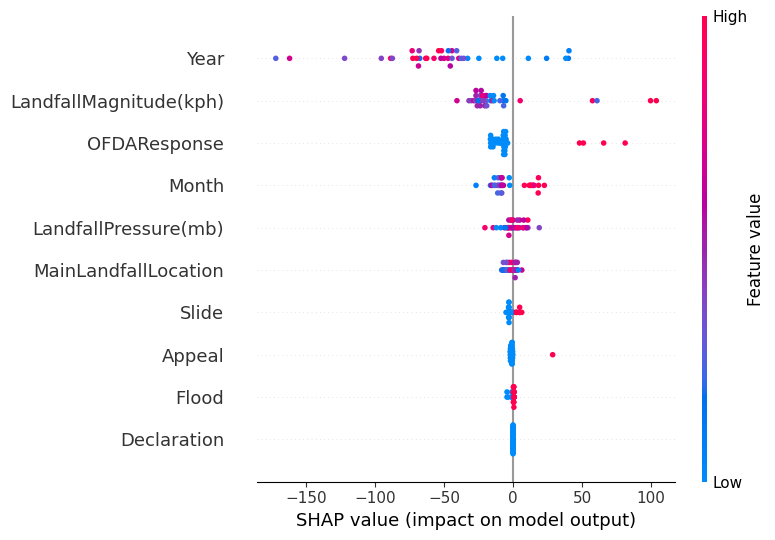

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.2.2 LightGBM

In [ ]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor()

In [ ]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


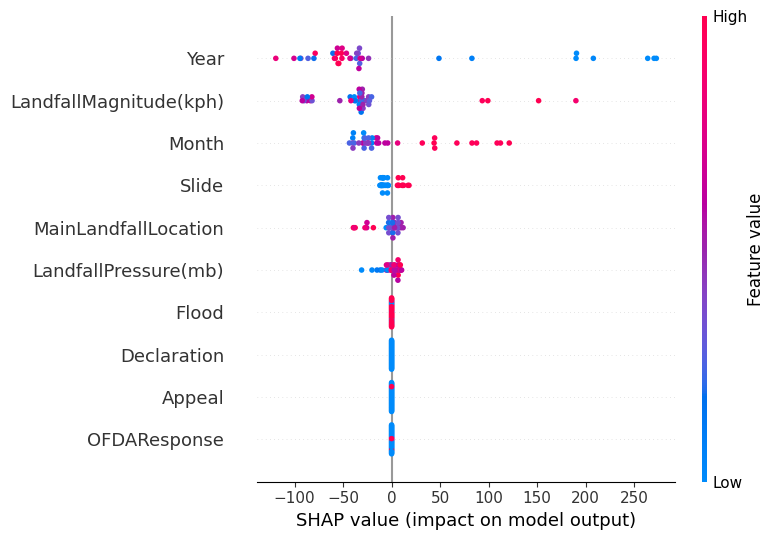

In [ ]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.2.3 CatBoost

In [ ]:
# !pip install catboost

In [ ]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 457us	remaining: 457ms
1:	learn: 471.3640040	total: 4.8ms	remaining: 2.4s
2:	learn: 468.0167703	total: 5.78ms	remaining: 1.92s
3:	learn: 464.5655498	total: 7.04ms	remaining: 1.75s
4:	learn: 461.0471589	total: 8.18ms	remaining: 1.63s
5:	learn: 457.8991406	total: 9.17ms	remaining: 1.52s
6:	learn: 454.6768441	total: 10ms	remaining: 1.42s
7:	learn: 451.5365131	total: 10.9ms	remaining: 1.35s
8:	learn: 448.4834973	total: 12.1ms	remaining: 1.33s
9:	learn: 445.1840673	total: 13.5ms	remaining: 1.33s
10:	learn: 441.9371963	total: 16ms	remaining: 1.44s
11:	learn: 438.6976759	total: 16.6ms	remaining: 1.37s
12:	learn: 435.4896915	total: 17.1ms	remaining: 1.3s
13:	learn: 432.2595625	total: 28.5ms	remaining: 2.01s
14:	learn: 429.0760846	total: 29ms	remaining: 1.91s
15:	learn: 426.1680837	total: 29.5ms	remaining: 1.82s
16:	learn: 423.0339016	total: 35.8ms	remaining: 2.07s
17:	learn: 419.9474727	total: 36.2ms	remaining: 1.98s
18:	learn: 416.833

In [ ]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


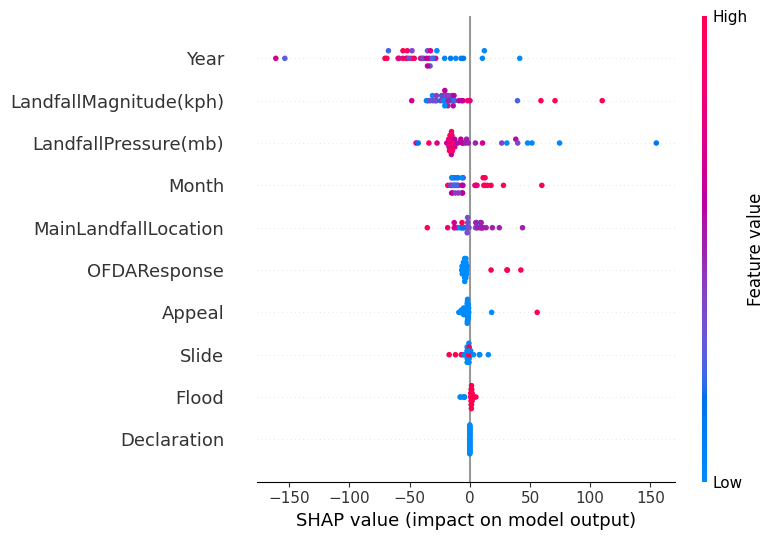

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.2.4 Decision Trees (GBDT)

In [ ]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.412714
7    LandfallPressure(mb)    0.326278
6  LandfallMagnitude(kph)    0.162266
2    MainLandfallLocation    0.059653
9                   Slide    0.022466
1                   Month    0.009822
4                  Appeal    0.003279
3            OFDAResponse    0.003218
8                   Flood    0.000304
5             Declaration    0.000000


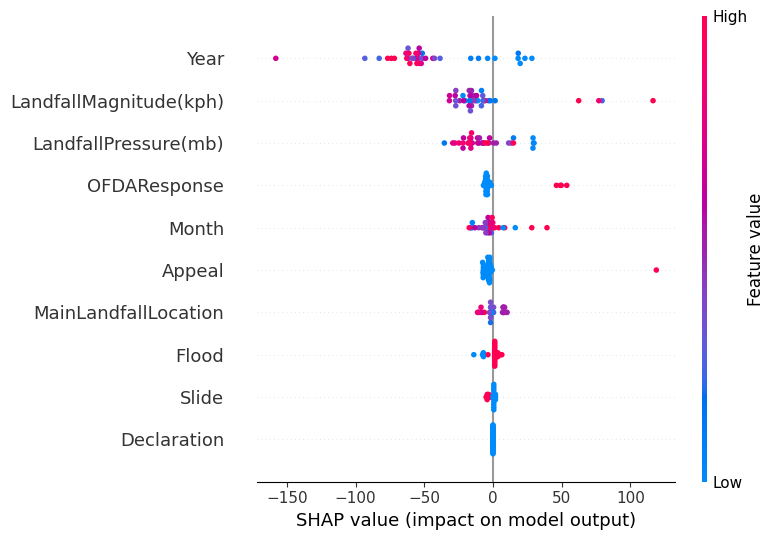

In [ ]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.5 COMPARISION

In [ ]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        1.0       1.0       1.0   1.0         1.000
LandfallMagnitude(kph)      2.0       3.0       3.0   3.0         2.750
LandfallPressure(mb)        5.0       4.0       2.0   2.0         3.250
MainLandfallLocation        3.0       6.0       4.0   4.0         4.250
Month                       4.0       2.0       5.0   6.0         4.250
Slide                       8.0       5.0       6.0   5.0         6.000
Appeal                      7.0       8.5       7.0   7.0         7.375
OFDAResponse                6.0       8.5       8.0   8.0         7.625
Flood                       9.0       8.5       9.0   9.0         8.875
Declaration                10.0       8.5      10.0  10.0         9.625


In [ ]:
models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)

mean_abs_shap_df['Avg SHAP'] = mean_abs_shap_df.mean(axis=1)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=False)

print("Sorted Mean Absolute SHAP Values Across Models:")
print(sorted_shap_df)

top_features = sorted_shap_df.head(7)
print("\nTop Features Selected Based on SHAP Values:")
print(top_features[['Avg SHAP']])


Sorted Mean Absolute SHAP Values Across Models:
                          XGBoost   LightGBM   CatBoost       GBDT   Avg SHAP
Year                    58.174931  85.295472  45.044696  51.300741  59.953960
LandfallMagnitude(kph)  26.624462  55.006275  25.662898  23.131096  32.606183
Month                   12.014859  38.545688  12.966990   7.856918  17.846114
LandfallPressure(mb)     5.550518   6.504171  24.649947  15.798750  13.125847
OFDAResponse            14.861990   0.000000   6.987665   9.324749   7.793601
MainLandfallLocation     3.558130   8.868778   9.778090   4.947266   6.788066
Slide                    3.092112   8.942786   3.263049   1.653016   4.237741
Appeal                   1.866562   0.000000   5.049287   6.992172   3.477005
Flood                    0.825314   0.000000   2.419387   3.166417   1.602780
Declaration              0.000000   0.000000   0.000000   0.000000   0.000000

Top Features Selected Based on SHAP Values:
                         Avg SHAP
Year           

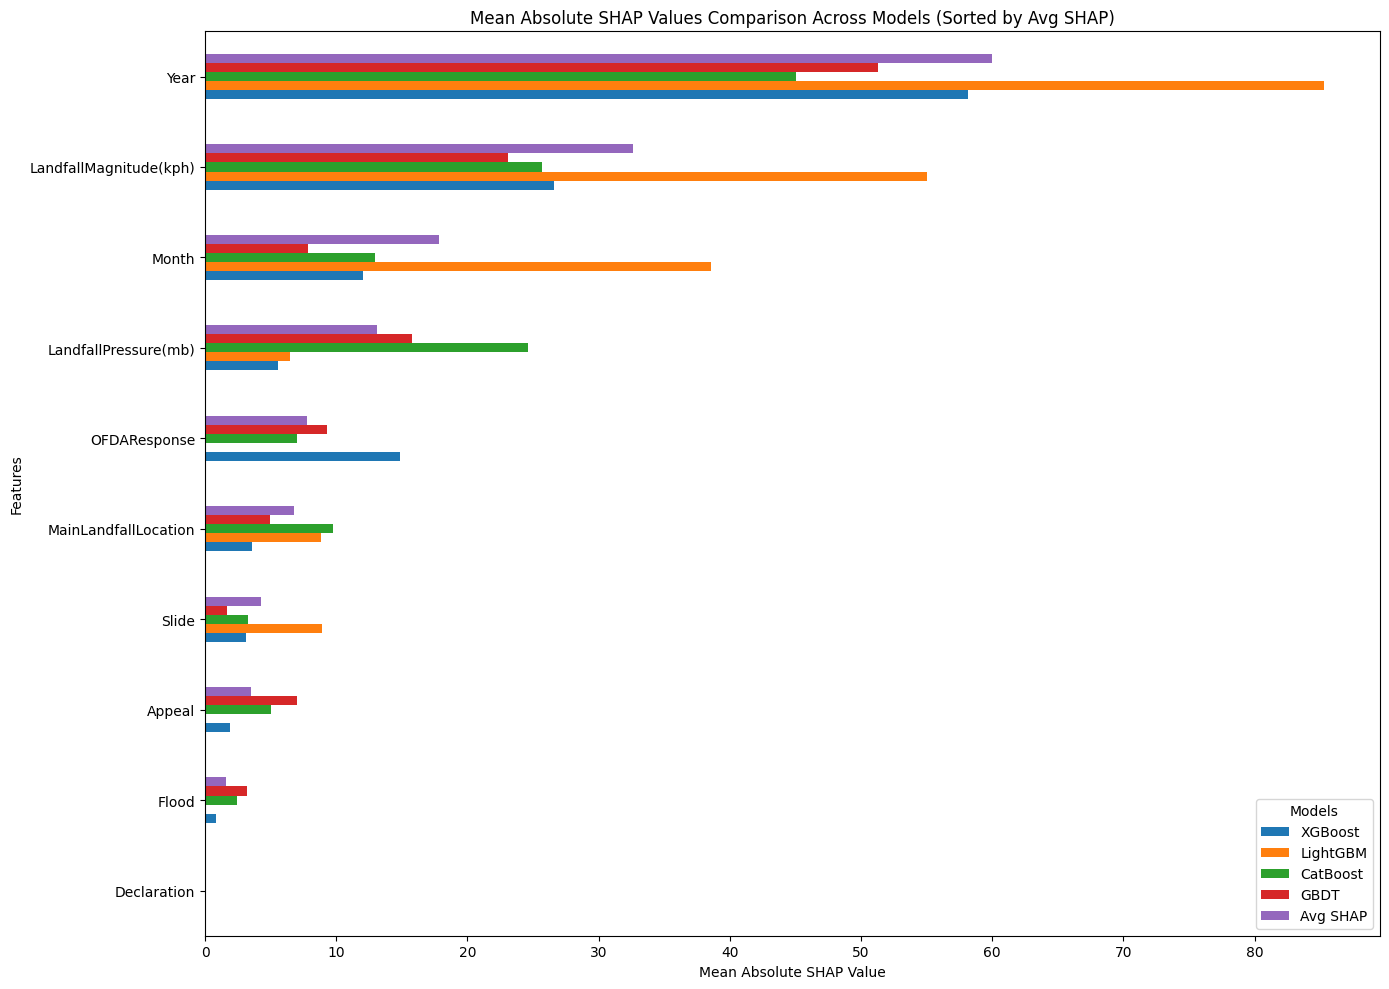

In [ ]:
mean_abs_shap_df.rename(columns={'Avg SHAP': 'Avg SHAP'}, inplace=True)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=True)

sorted_shap_df[['XGBoost', 'LightGBM', 'CatBoost', 'GBDT', 'Avg SHAP']].plot(kind='barh', figsize=(14, 10))
plt.title('Mean Absolute SHAP Values Comparison Across Models (Sorted by Avg SHAP)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.legend(title='Models', loc='lower right')
plt.tight_layout()
plt.show()

## 1.3.  Adjusted Damage

In [ ]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[2]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :TotalDamageAdjusted(000US$)
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.3.1 XGBOOST

In [ ]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


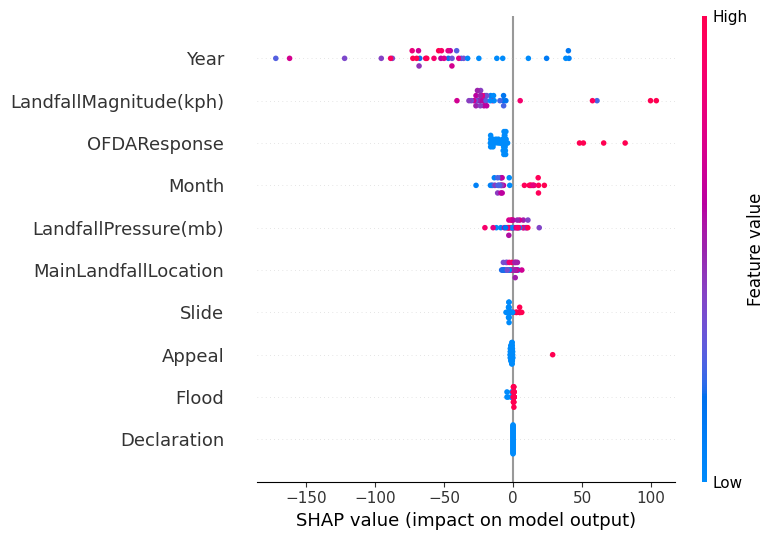

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.2 LightGBM

In [ ]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [ ]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


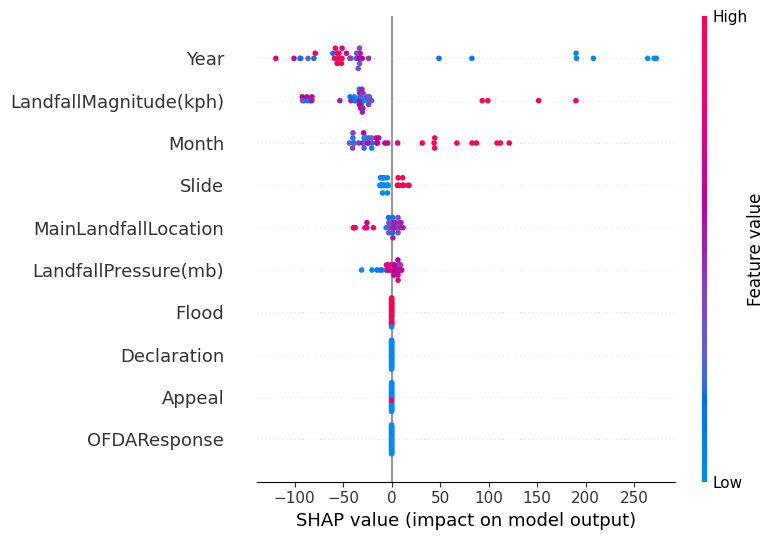

In [ ]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.3 CatBoost

In [ ]:
# !pip install catboost

In [ ]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 1.74ms	remaining: 1.74s
1:	learn: 471.3640040	total: 2.74ms	remaining: 1.37s
2:	learn: 468.0167703	total: 4.32ms	remaining: 1.44s
3:	learn: 464.5655498	total: 6.02ms	remaining: 1.5s
4:	learn: 461.0471589	total: 7.5ms	remaining: 1.49s
5:	learn: 457.8991406	total: 9.21ms	remaining: 1.52s
6:	learn: 454.6768441	total: 18ms	remaining: 2.55s
7:	learn: 451.5365131	total: 19.2ms	remaining: 2.37s
8:	learn: 448.4834973	total: 20.8ms	remaining: 2.29s
9:	learn: 445.1840673	total: 22.5ms	remaining: 2.22s
10:	learn: 441.9371963	total: 23.9ms	remaining: 2.15s
11:	learn: 438.6976759	total: 25.5ms	remaining: 2.1s
12:	learn: 435.4896915	total: 26.5ms	remaining: 2.01s
13:	learn: 432.2595625	total: 27.9ms	remaining: 1.97s
14:	learn: 429.0760846	total: 29.2ms	remaining: 1.92s
15:	learn: 426.1680837	total: 30.5ms	remaining: 1.87s
16:	learn: 423.0339016	total: 31.7ms	remaining: 1.83s
17:	learn: 419.9474727	total: 32.9ms	remaining: 1.8s
18:	learn: 416

In [ ]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


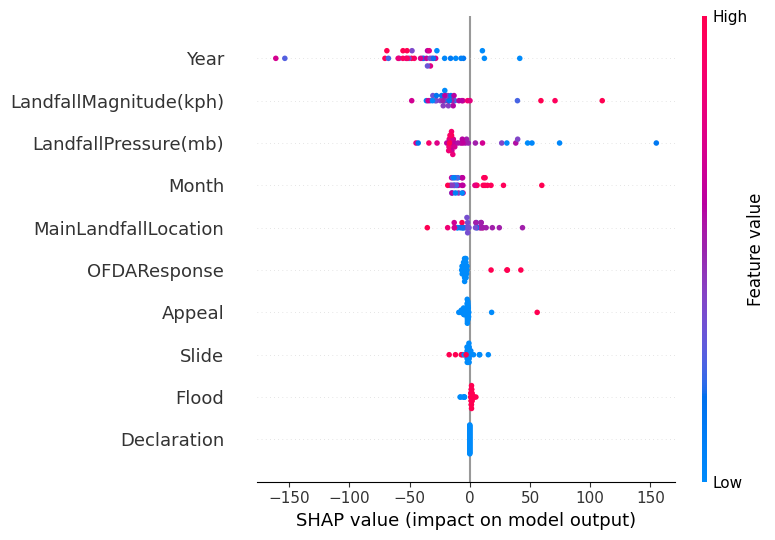

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.4 Decision Trees (GBDT)

In [ ]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.412245
6  LandfallMagnitude(kph)    0.312259
7    LandfallPressure(mb)    0.178767
2    MainLandfallLocation    0.044391
9                   Slide    0.035255
1                   Month    0.009719
4                  Appeal    0.003388
3            OFDAResponse    0.003109
8                   Flood    0.000867
5             Declaration    0.000000


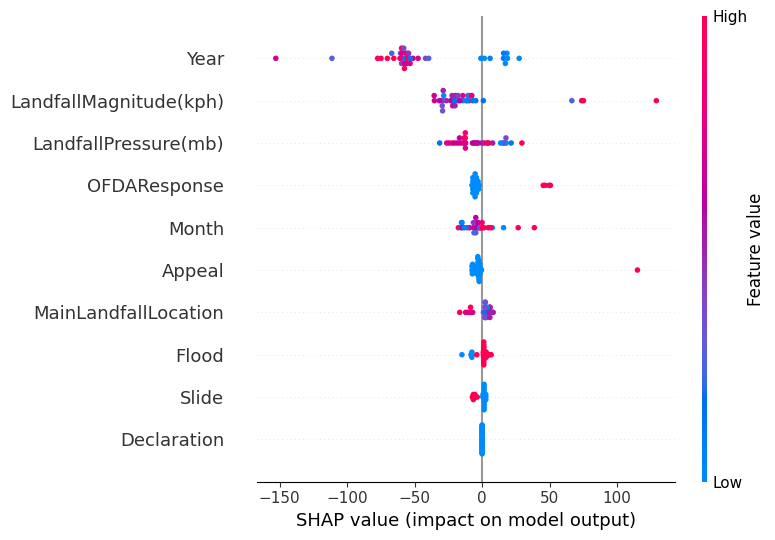

In [ ]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.1.5 COMPARISION

In [ ]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        1.0       1.0       1.0   1.0         1.000
LandfallMagnitude(kph)      2.0       3.0       3.0   2.0         2.500
LandfallPressure(mb)        5.0       4.0       2.0   3.0         3.500
MainLandfallLocation        3.0       6.0       4.0   4.0         4.250
Month                       4.0       2.0       5.0   6.0         4.250
Slide                       8.0       5.0       6.0   5.0         6.000
Appeal                      7.0       8.5       7.0   7.0         7.375
OFDAResponse                6.0       8.5       8.0   8.0         7.625
Flood                       9.0       8.5       9.0   9.0         8.875
Declaration                10.0       8.5      10.0  10.0         9.625


In [ ]:
models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)

mean_abs_shap_df['Avg SHAP'] = mean_abs_shap_df.mean(axis=1)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=False)

print("Sorted Mean Absolute SHAP Values Across Models:")
print(sorted_shap_df)

top_features = sorted_shap_df.head(7)
print("\nTop Features Selected Based on SHAP Values:")
print(top_features[['Avg SHAP']])


Sorted Mean Absolute SHAP Values Across Models:
                          XGBoost   LightGBM   CatBoost       GBDT   Avg SHAP
Year                    58.174931  85.295472  45.044696  51.204582  59.929920
LandfallMagnitude(kph)  26.624462  55.006275  25.662898  26.734070  33.506926
Month                   12.014859  38.545688  12.966990   7.893510  17.855262
LandfallPressure(mb)     5.550518   6.504171  24.649947  13.367004  12.517910
OFDAResponse            14.861990   0.000000   6.987665   9.649759   7.874853
MainLandfallLocation     3.558130   8.868778   9.778090   5.164832   6.842458
Slide                    3.092112   8.942786   3.263049   2.823226   4.530293
Appeal                   1.866562   0.000000   5.049287   6.705201   3.405263
Flood                    0.825314   0.000000   2.419387   3.209618   1.613580
Declaration              0.000000   0.000000   0.000000   0.000000   0.000000

Top Features Selected Based on SHAP Values:
                         Avg SHAP
Year           

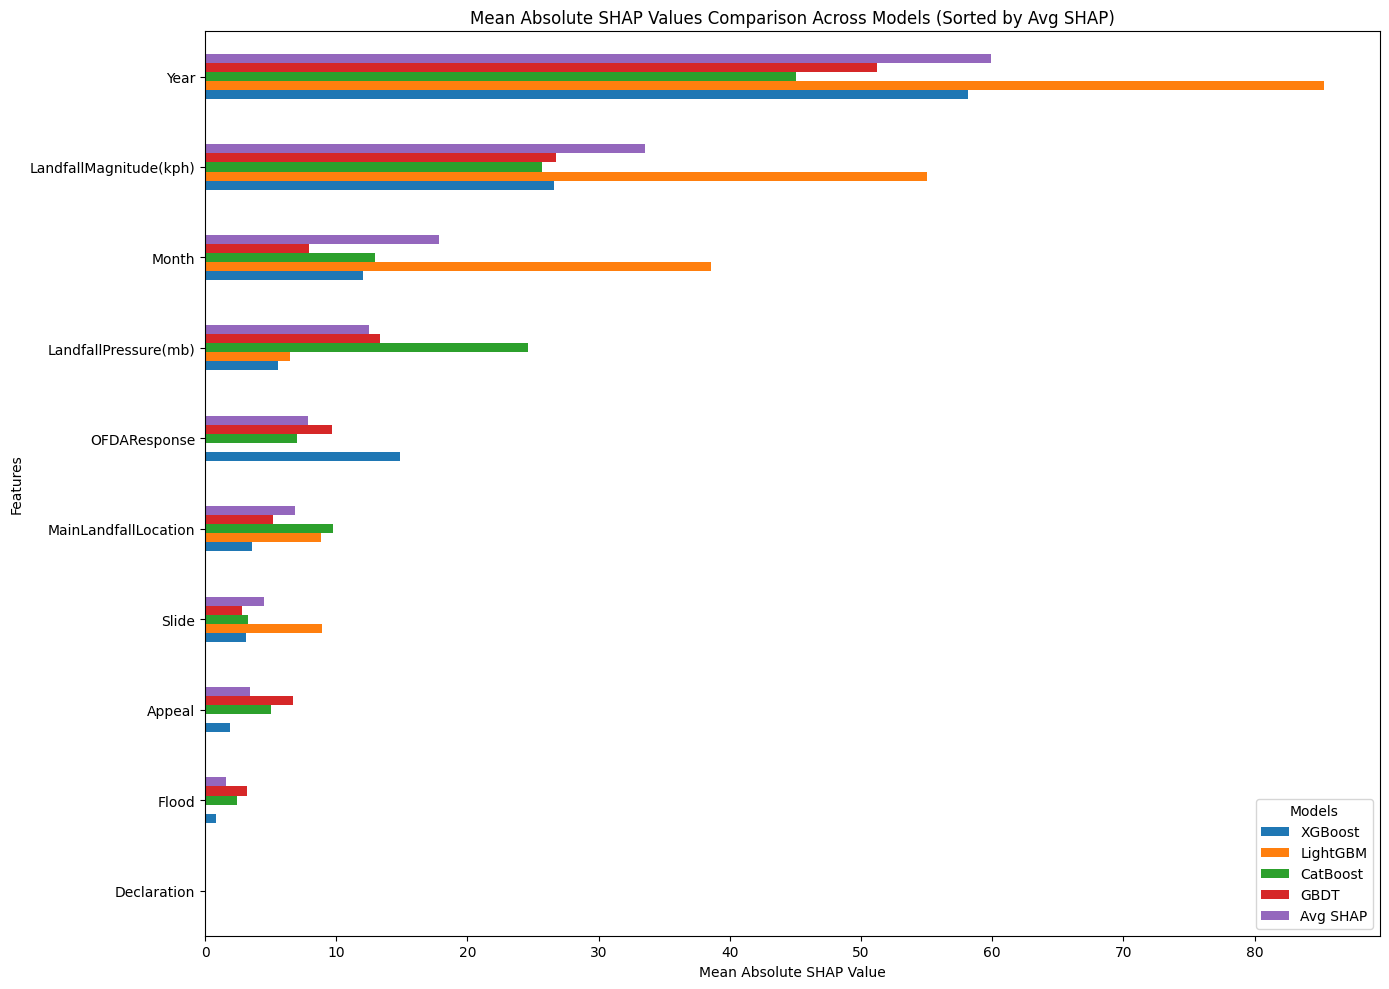

In [ ]:
mean_abs_shap_df.rename(columns={'Avg SHAP': 'Avg SHAP'}, inplace=True)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=True)

sorted_shap_df[['XGBoost', 'LightGBM', 'CatBoost', 'GBDT', 'Avg SHAP']].plot(kind='barh', figsize=(14, 10))
plt.title('Mean Absolute SHAP Values Comparison Across Models (Sorted by Avg SHAP)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.legend(title='Models', loc='lower right')
plt.tight_layout()
plt.show()

# 2. CATEGORICAL_TARGET


## 1.1.  Flood

In [ ]:
evaluate_dict = dict()

print(f"CATEGORICAL_TARGETS :{CATEGORICAL_TARGETS[0]}")
print(f"ATTRIBUTES :{ATTRIBUTES}")
feature_names = ATTRIBUTES

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES]
y = slide_df[CATEGORICAL_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

CATEGORICAL_TARGETS :Flood
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']
Train size 147
Test size: 37


### 2.1.1 XGBOOST

In [ ]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
1                   Month    0.303616
7    LandfallPressure(mb)    0.263389
0                    Year    0.157937
2    MainLandfallLocation    0.149520
6  LandfallMagnitude(kph)    0.118989
3            OFDAResponse    0.004550
4                  Appeal    0.002000
5             Declaration    0.000000


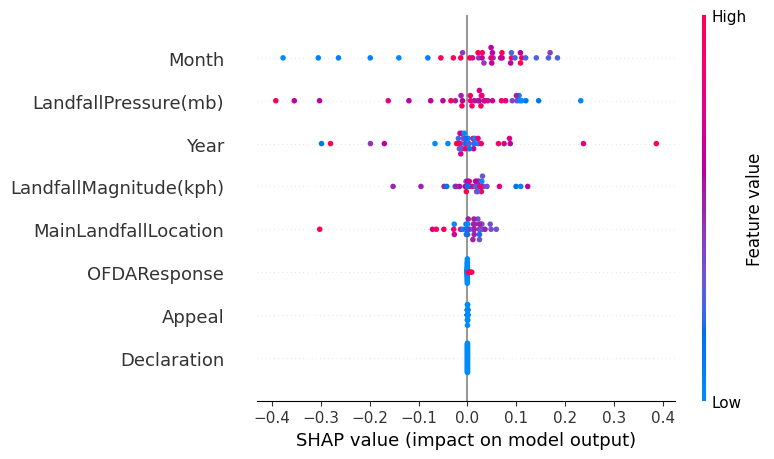

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.2 LightGBM

In [ ]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 5
[LightGBM] [Info] Start training from score 0.829932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMRegressor()

In [ ]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         151
7    LandfallPressure(mb)         100
6  LandfallMagnitude(kph)          99
2    MainLandfallLocation          57
1                   Month          54
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0


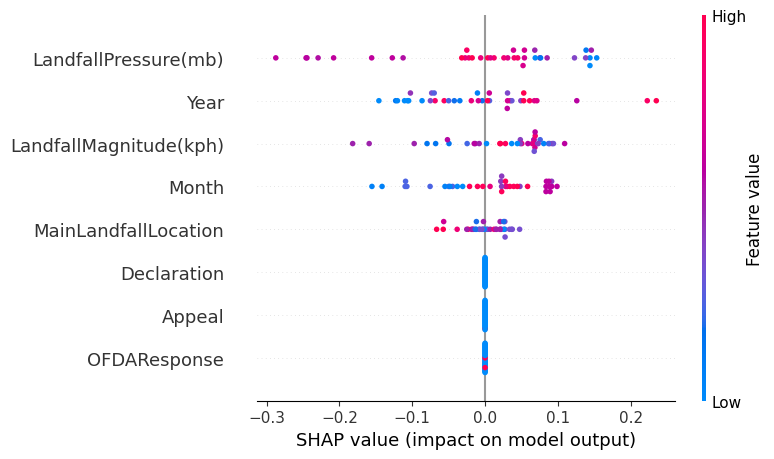

In [ ]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.3 CatBoost

In [ ]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 0.3736679	total: 494us	remaining: 494ms
1:	learn: 0.3709531	total: 852us	remaining: 426ms
2:	learn: 0.3689776	total: 3.57ms	remaining: 1.19s
3:	learn: 0.3669878	total: 4.48ms	remaining: 1.12s
4:	learn: 0.3646340	total: 5.58ms	remaining: 1.11s
5:	learn: 0.3618291	total: 6.14ms	remaining: 1.02s
6:	learn: 0.3585311	total: 6.8ms	remaining: 965ms
7:	learn: 0.3573671	total: 7.55ms	remaining: 936ms
8:	learn: 0.3554138	total: 8.16ms	remaining: 899ms
9:	learn: 0.3525755	total: 8.7ms	remaining: 861ms
10:	learn: 0.3507109	total: 9.27ms	remaining: 833ms
11:	learn: 0.3486745	total: 10.1ms	remaining: 828ms
12:	learn: 0.3462853	total: 10.9ms	remaining: 827ms
13:	learn: 0.3443763	total: 11.2ms	remaining: 788ms
14:	learn: 0.3426802	total: 11.7ms	remaining: 770ms
15:	learn: 0.3408363	total: 12.4ms	remaining: 762ms
16:	learn: 0.3391814	total: 13.5ms	remaining: 780ms
17:	learn: 0.3376704	total: 14.7ms	remaining: 802ms
18:	learn: 0.3341124	total: 15.7ms	remaining: 81

In [ ]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
1                   Month   24.222477
7    LandfallPressure(mb)   23.301976
0                    Year   22.878854
6  LandfallMagnitude(kph)   16.453045
2    MainLandfallLocation   12.177419
3            OFDAResponse    0.556520
4                  Appeal    0.409709
5             Declaration    0.000000


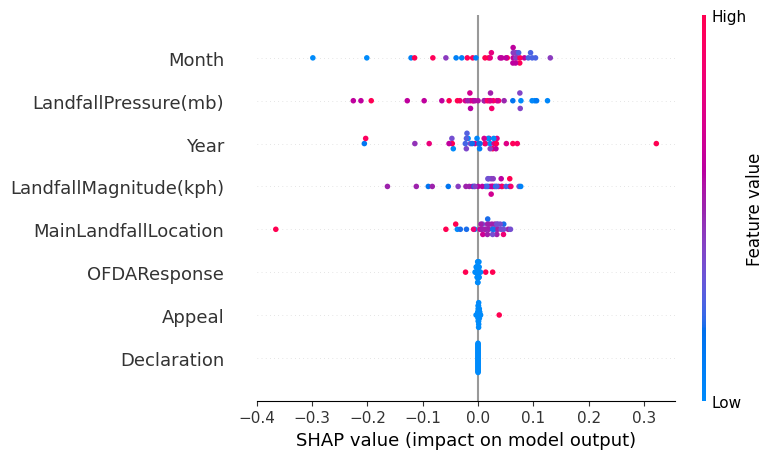

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.4 Decision Trees (GBDT)

In [ ]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.367599
1                   Month    0.268609
7    LandfallPressure(mb)    0.201129
6  LandfallMagnitude(kph)    0.115048
2    MainLandfallLocation    0.043687
4                  Appeal    0.003927
3            OFDAResponse    0.000000
5             Declaration    0.000000


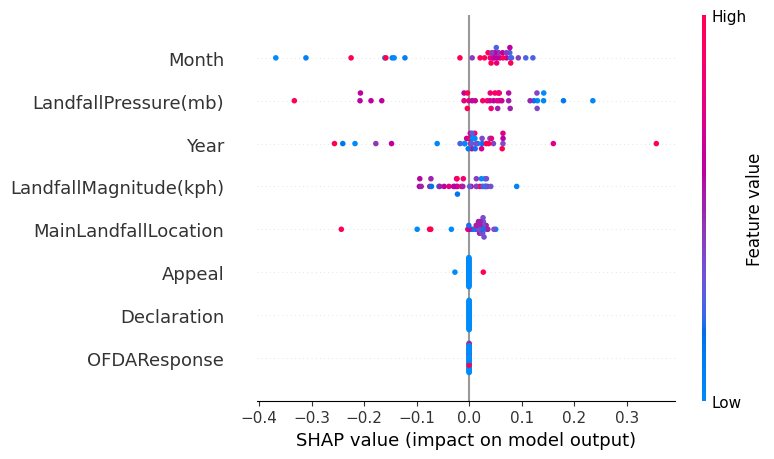

In [ ]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.5 COMPARISION

In [ ]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        3.0       1.0       3.0   1.0         2.000
Month                       1.0       5.0       1.0   2.0         2.250
LandfallPressure(mb)        2.0       2.0       2.0   3.0         2.250
LandfallMagnitude(kph)      5.0       3.0       4.0   4.0         4.000
MainLandfallLocation        4.0       4.0       5.0   5.0         4.500
OFDAResponse                6.0       7.0       6.0   7.5         6.625
Appeal                      7.0       7.0       7.0   6.0         6.750
Declaration                 8.0       7.0       8.0   7.5         7.625


In [ ]:
models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)

mean_abs_shap_df['Avg SHAP'] = mean_abs_shap_df.mean(axis=1)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=False)

print("Sorted Mean Absolute SHAP Values Across Models:")
print(sorted_shap_df)

top_features = sorted_shap_df.head(7)
print("\nTop Features Selected Based on SHAP Values:")
print(top_features[['Avg SHAP']])


Sorted Mean Absolute SHAP Values Across Models:
                         XGBoost  LightGBM  CatBoost      GBDT  Avg SHAP
LandfallPressure(mb)    0.085563  0.093745  0.058125  0.089702  0.081784
Month                   0.096223  0.059665  0.072081  0.089840  0.079452
Year                    0.062273  0.068431  0.047445  0.061569  0.059930
LandfallMagnitude(kph)  0.033028  0.063464  0.039849  0.037133  0.043369
MainLandfallLocation    0.030322  0.021902  0.036761  0.032685  0.030418
Appeal                  0.000248  0.000000  0.002364  0.001802  0.001104
OFDAResponse            0.000760  0.000000  0.003200  0.000000  0.000990
Declaration             0.000000  0.000000  0.000000  0.000000  0.000000

Top Features Selected Based on SHAP Values:
                        Avg SHAP
LandfallPressure(mb)    0.081784
Month                   0.079452
Year                    0.059930
LandfallMagnitude(kph)  0.043369
MainLandfallLocation    0.030418
Appeal                  0.001104
OFDAResponse       

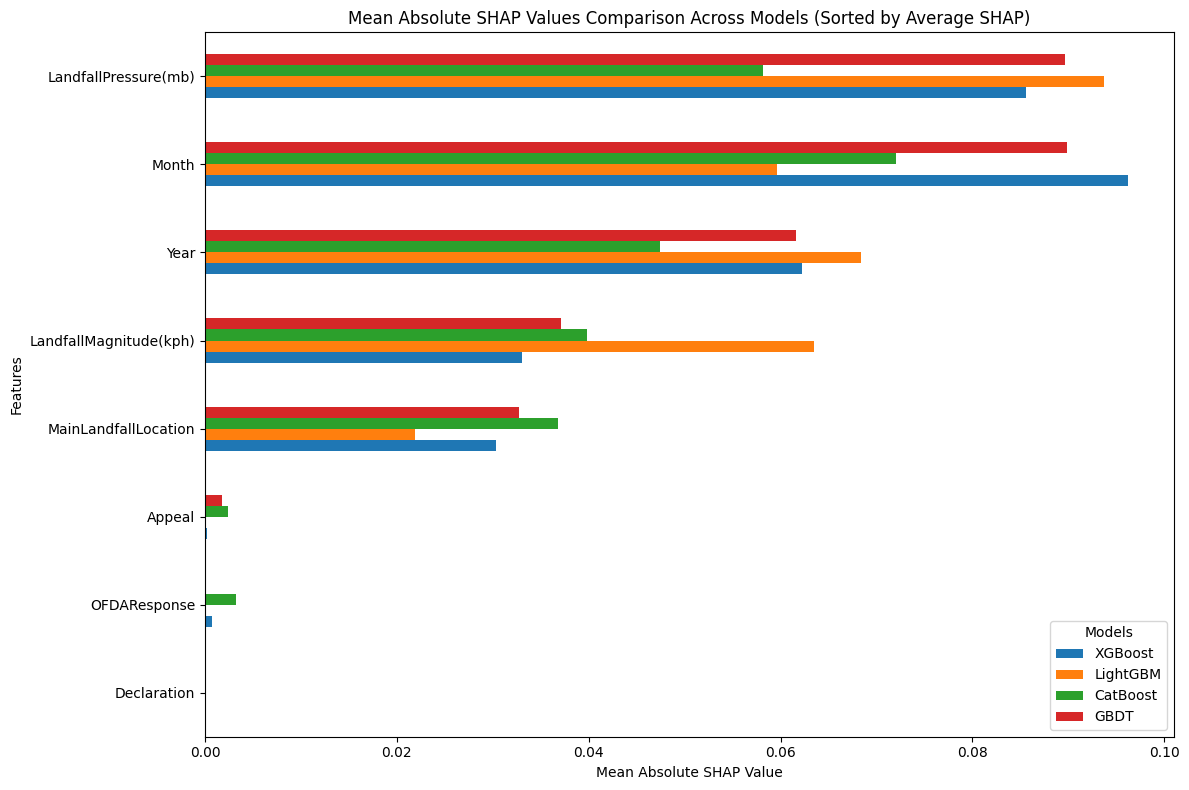

In [ ]:
mean_abs_shap_df.rename(columns={'Avg SHAP': 'Avg SHAP'}, inplace=True)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=True)

sorted_shap_df[['XGBoost', 'LightGBM', 'CatBoost', 'GBDT', 'Avg SHAP']].plot(kind='barh', figsize=(14, 10))
plt.title('Mean Absolute SHAP Values Comparison Across Models (Sorted by Avg SHAP)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.legend(title='Models', loc='lower right')
plt.tight_layout()
plt.show()

## 2.2.  Slide

In [ ]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"CATEGORICAL_TARGETS :{CATEGORICAL_TARGETS[1]}")
print(f"ATTRIBUTES :{ATTRIBUTES}")
feature_names = ATTRIBUTES

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES]
y = slide_df[CATEGORICAL_TARGETS[1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

CATEGORICAL_TARGETS :Slide
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']
Train size 147
Test size: 37


### 2.2.1 XGBOOST

In [ ]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
4                  Appeal    0.329285
3            OFDAResponse    0.148877
7    LandfallPressure(mb)    0.136016
2    MainLandfallLocation    0.111162
6  LandfallMagnitude(kph)    0.103988
0                    Year    0.085556
1                   Month    0.085117
5             Declaration    0.000000


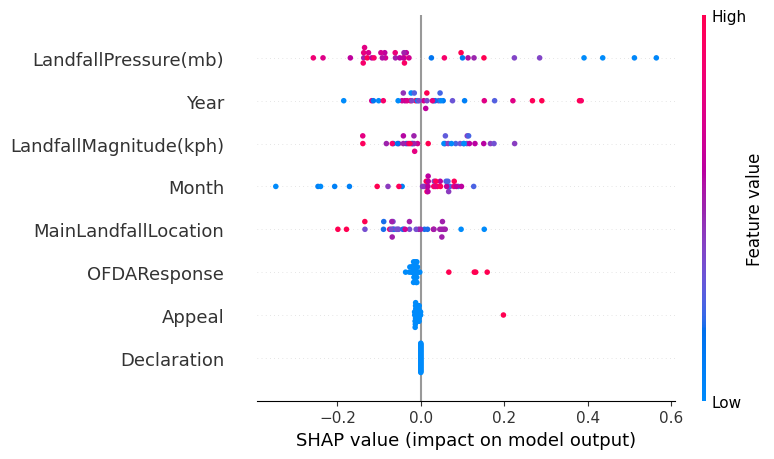

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.2.2 LightGBM

In [ ]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 5
[LightGBM] [Info] Start training from score 0.374150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [ ]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         172
6  LandfallMagnitude(kph)          93
2    MainLandfallLocation          66
7    LandfallPressure(mb)          62
1                   Month          56
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0


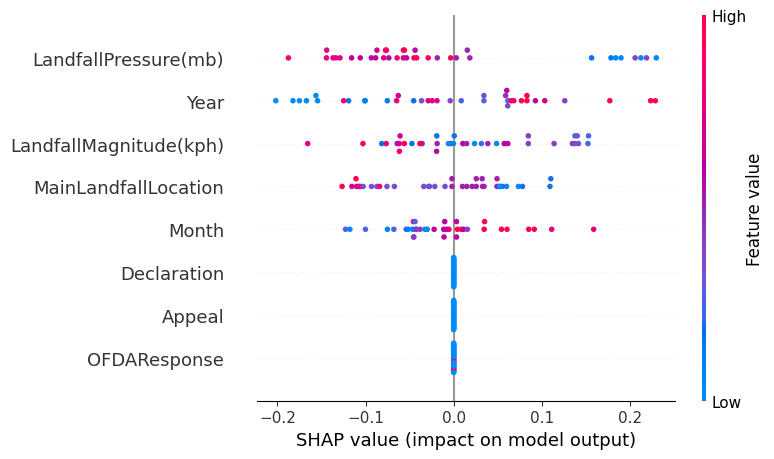

In [ ]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.2.3 CatBoost

In [ ]:
# !pip install catboost

In [ ]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 0.4832480	total: 367us	remaining: 367ms
1:	learn: 0.4814859	total: 1.11ms	remaining: 555ms
2:	learn: 0.4807739	total: 1.58ms	remaining: 525ms
3:	learn: 0.4801573	total: 2.09ms	remaining: 519ms
4:	learn: 0.4787167	total: 2.71ms	remaining: 539ms
5:	learn: 0.4768916	total: 3.31ms	remaining: 548ms
6:	learn: 0.4749873	total: 3.9ms	remaining: 553ms
7:	learn: 0.4741913	total: 4.46ms	remaining: 552ms
8:	learn: 0.4727953	total: 5.05ms	remaining: 556ms
9:	learn: 0.4712711	total: 5.76ms	remaining: 570ms
10:	learn: 0.4704114	total: 6.36ms	remaining: 571ms
11:	learn: 0.4685792	total: 6.97ms	remaining: 574ms
12:	learn: 0.4670738	total: 7.67ms	remaining: 583ms
13:	learn: 0.4659621	total: 8.22ms	remaining: 579ms
14:	learn: 0.4642665	total: 8.78ms	remaining: 576ms
15:	learn: 0.4630175	total: 9.47ms	remaining: 583ms
16:	learn: 0.4614651	total: 9.86ms	remaining: 570ms
17:	learn: 0.4595074	total: 10.2ms	remaining: 557ms
18:	learn: 0.4589035	total: 10.5ms	remaining: 

In [ ]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   26.783603
7    LandfallPressure(mb)   23.833091
6  LandfallMagnitude(kph)   17.130593
2    MainLandfallLocation   16.186391
1                   Month   12.403057
3            OFDAResponse    1.994169
4                  Appeal    1.669096
5             Declaration    0.000000


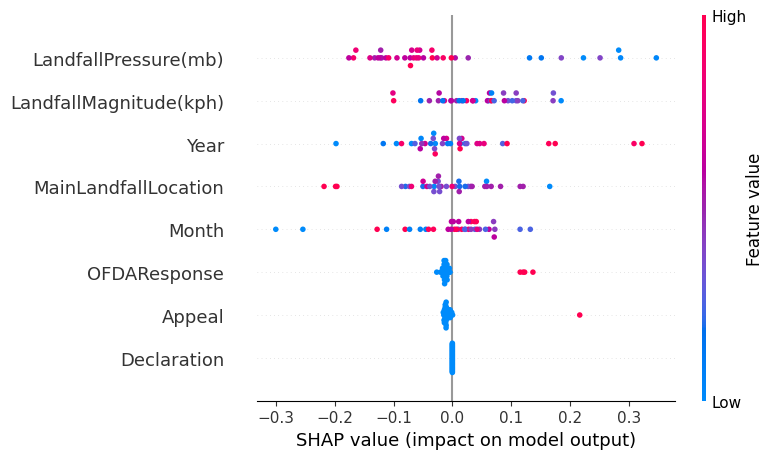

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.2.4 Decision Trees (GBDT)

In [ ]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
7    LandfallPressure(mb)    0.306566
0                    Year    0.235075
6  LandfallMagnitude(kph)    0.184666
1                   Month    0.133975
2    MainLandfallLocation    0.080528
4                  Appeal    0.041969
3            OFDAResponse    0.017220
5             Declaration    0.000000


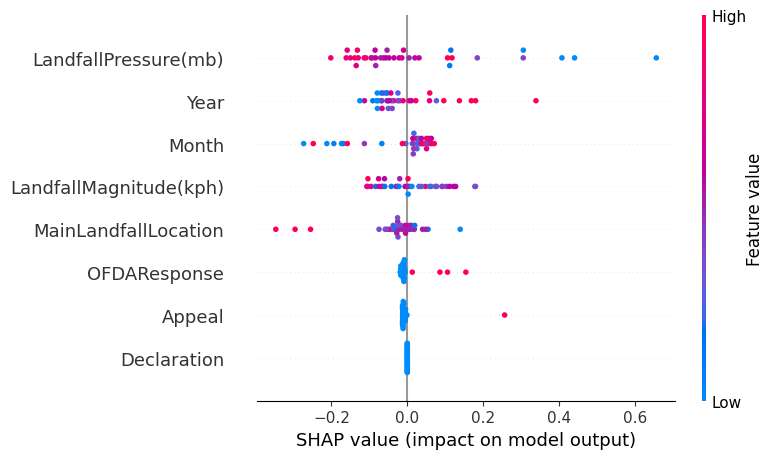

In [ ]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.2.5 COMPARISION

In [ ]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
LandfallPressure(mb)        3.0       4.0       2.0   1.0          2.50
Year                        6.0       1.0       1.0   2.0          2.50
LandfallMagnitude(kph)      5.0       2.0       3.0   3.0          3.25
MainLandfallLocation        4.0       3.0       4.0   5.0          4.00
Appeal                      1.0       7.0       7.0   6.0          5.25
Month                       7.0       5.0       5.0   4.0          5.25
OFDAResponse                2.0       7.0       6.0   7.0          5.50
Declaration                 8.0       7.0       8.0   8.0          7.75


In [ ]:
models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)

mean_abs_shap_df['Avg SHAP'] = mean_abs_shap_df.mean(axis=1)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=False)

print("Sorted Mean Absolute SHAP Values Across Models:")
print(sorted_shap_df)

top_features = sorted_shap_df.head(7)
print("\nTop Features Selected Based on SHAP Values:")
print(top_features[['Avg SHAP']])


Sorted Mean Absolute SHAP Values Across Models:
                         XGBoost  LightGBM  CatBoost      GBDT  Avg SHAP
LandfallPressure(mb)    0.149520  0.101498  0.114326  0.136470  0.125454
Year                    0.089609  0.094343  0.067106  0.072677  0.080934
LandfallMagnitude(kph)  0.078139  0.067222  0.067169  0.066492  0.069756
Month                   0.076519  0.047226  0.057449  0.070548  0.062935
MainLandfallLocation    0.064288  0.059386  0.059225  0.052346  0.058812
OFDAResponse            0.026885  0.000000  0.024411  0.020077  0.017843
Appeal                  0.013532  0.000000  0.014810  0.016350  0.011173
Declaration             0.000000  0.000000  0.000000  0.000000  0.000000

Top Features Selected Based on SHAP Values:
                        Avg SHAP
LandfallPressure(mb)    0.125454
Year                    0.080934
LandfallMagnitude(kph)  0.069756
Month                   0.062935
MainLandfallLocation    0.058812
OFDAResponse            0.017843
Appeal             

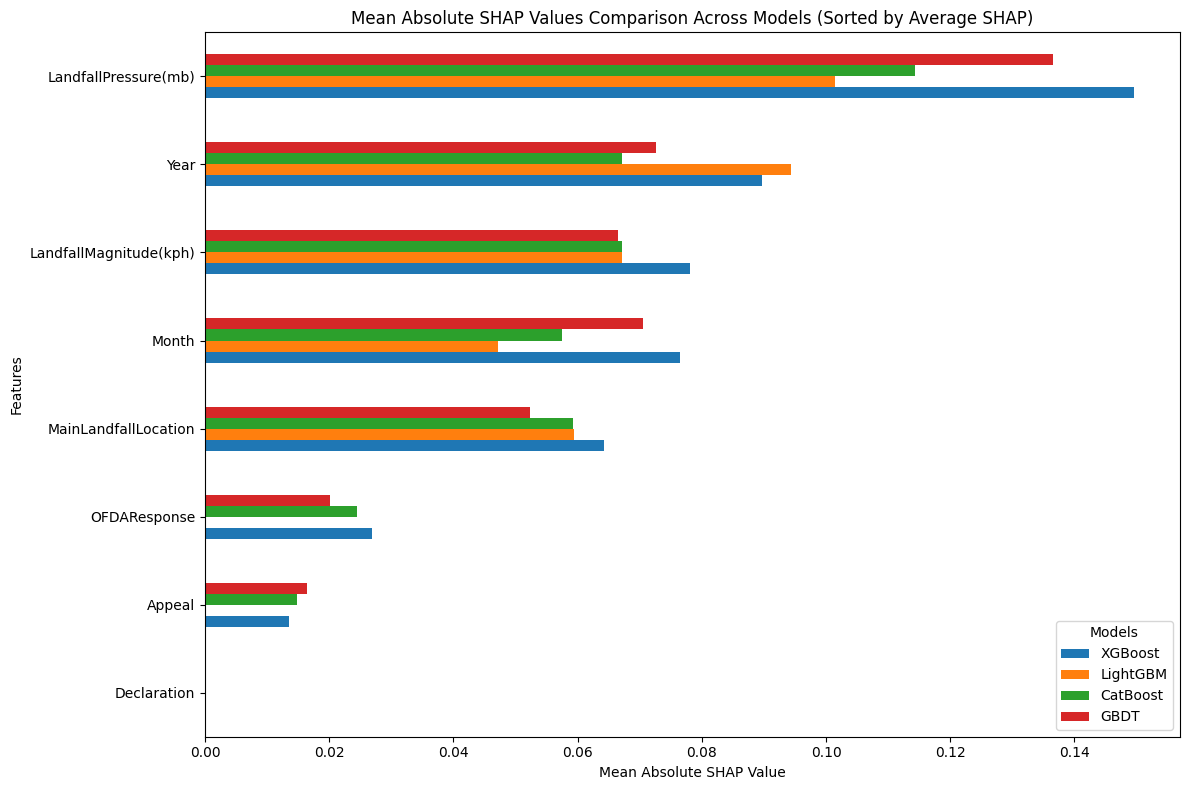

In [ ]:
mean_abs_shap_df.rename(columns={'Avg SHAP': 'Avg SHAP'}, inplace=True)
sorted_shap_df = mean_abs_shap_df.sort_values(by='Avg SHAP', ascending=True)

sorted_shap_df[['XGBoost', 'LightGBM', 'CatBoost', 'GBDT', 'Avg SHAP']].plot(kind='barh', figsize=(14, 10))
plt.title('Mean Absolute SHAP Values Comparison Across Models (Sorted by Avg SHAP)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.legend(title='Models', loc='lower right')
plt.tight_layout()
plt.show()